# Market Shock Recovery Patterns: Statistical Analysis of S&P 500 Stock Reactions

----

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
import yfinance as yf
import pandas as pd
import plotly.express as px

#### Table of Contents 

1. [Introduction](#1ntroduction)
2. [Theoretical Framework & Methodology](#2-theoretical-framework--methodology)
3. [Data Collection & Preparation](#3-data-collection--preparation)
4. [Identifying Crashes](#4-identifying-crashes)



## 1. Introduction

This project aims to analyze and understand potential abnormal reactions of the S&P 500 to stock market shocks from 2015 to 2025. Specifically, it tests whether large market crashes are followed by **statistically significant** positive returns consistent with return reversals or investor overreaction (De Bondt and Thaler, 1995). For the investor, this translates to whether they can profit by buying stocks right after a market crash. 

The COVID-19 crash of March 2020 caused a 34% fall on the S&P 500 in just 23 days, yet stocks recovered most losses within weeks. By the end of 2020, the market was significantly higher than its initial value before the pandemic. More recently, Trump's *Liberation Day* led to losses amounting to over 10% of the S&P 500 companies, followed by a full recovery a month later. 

Understanding post-shock returns is crucial for many reasons:
- Investors deciding whether to buy during market panic
- Risk managers assessing portfolio behavior during stress periods
- Academics testing market efficiency (EMH)



## 2. Theoretical Framework & Methodology

### Market Crash

A market crash is an unusually large single-day S&P 500 decline. It is calculated based on the close-to-close return from day $t-1$ to day $t$. Similarly for individual stocks, a large negative shock is a sudden drop in price. Although such declines are often characterized by fixed thresholds, like losses of 3-5% or more, these absolute values may not show the same relevance across firms. Since companies have different characteristics, like volatility, the use of a relative measure is better suited to our objective.


To illustrate the flaw in using absolute thresholds, let's briefly look at market shocks for two companies: Apple and Tesla.

In [4]:
apple = yf.download("AAPL", start="2015-01-01", end="2025-12-31")
tesla = yf.download("TSLA", start="2015-01-01", end="2025-12-31")
threshold = -0.05

apple["Daily Return"] = apple["Close"].pct_change()
tesla["Daily Return"] = tesla["Close"].pct_change()

apple_crash_days = apple[apple["Daily Return"] <= threshold]
tesla_crash_days = tesla[tesla["Daily Return"] <= threshold]

print(f"Number of \"crash\" days for Apple: {len(apple_crash_days)}")
print(f"Number of \"crash\" days for Tesla: {len(tesla_crash_days)}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Number of "crash" days for Apple: 24
Number of "crash" days for Tesla: 161


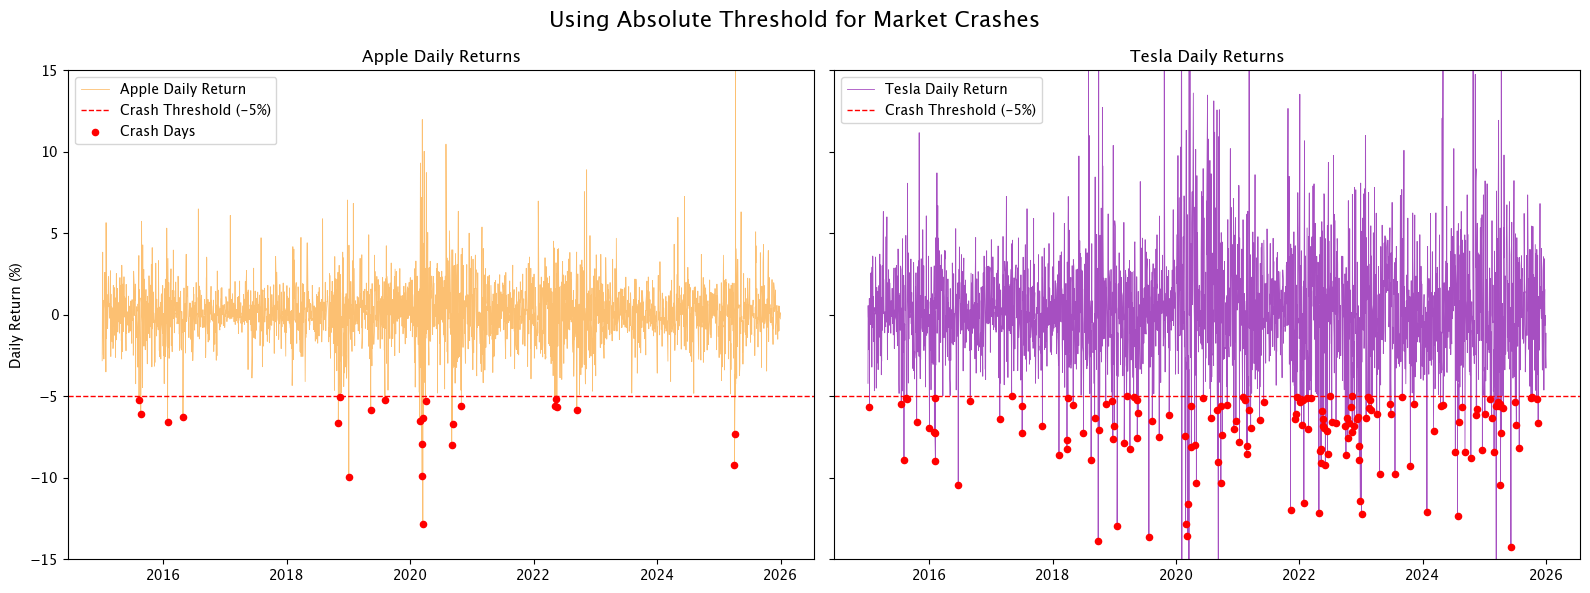

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

y_min = -15
y_max = 15

# Apple
ax1.plot(apple.index, apple["Daily Return"] * 100, label='Apple Daily Return', linewidth=0.6, color=cm.plasma(0.8), alpha=0.7)
ax1.axhline(y=-5, color='red', linestyle='--', linewidth=1, label='Crash Threshold (-5%)')
ax1.scatter(apple_crash_days.index, apple_crash_days['Daily Return'] * 100, color='red', s=20, zorder=5, label='Crash Days')
ax1.set_title('Apple Daily Returns')
ax1.set_ylabel('Daily Return (%)')
ax1.set_ylim(y_min, y_max)
ax1.legend()

# Tesla
ax2.plot(tesla.index, tesla["Daily Return"] * 100, label='Tesla Daily Return', linewidth=0.6, color=cm.plasma(0.26), alpha=0.7)
ax2.axhline(y=-5, color='red', linestyle='--', linewidth=1, label='Crash Threshold (-5%)')
ax2.scatter(tesla_crash_days.index, tesla_crash_days['Daily Return'] * 100, color='red', s=20, zorder=5)                
ax2.set_title('Tesla Daily Returns')
ax2.set_ylim(y_min, y_max) 
ax2.legend()

plt.suptitle("Using Absolute Threshold for Market Crashes", fontsize=16)
plt.tight_layout()
plt.show()

Using the same 5% threshold yields vastly different results for both companies. Under this definition, Apple would experience roughly 7 times less "crashes" than Tesla. But since Tesla's volatility is significantly higher, such comparison is generally misleading. The same percentage decline may represent a routine fluctuation for a high-volatility stock but an extreme event for a more stable firm.

Instead, we may adopt a more comprehensive measure by defining a crash as a day on which the return decreases below the **mean daily return minus two standard deviations**. By noting $r_t$ the daily return, $\mu$ the mean daily return from 2015 to 2025 and $\sigma$ the corresponding standard deviation, we may formalize a market crash or shock as a day when: 

$$r_t< \mu - 2\sigma$$

Under the assumption that returns are *approximately* normally distributed, about 95% of observations lie within two standard deviations of the mean. Consequently, a return below $\mu - 2\sigma$ corresponds to roughly the lowest 2.5% of outcomes, which translates to statistically rare negative movements. 

### Abnormal Returns & CPAM

To determine if a stock's recovery is *exceptional*, we first need to determine what "normal" recovery looks like. We use the concept of **abnormal returns**:

$$\text{Abnormal Return} = \text{Actual Return} - \text{Expected Return}$$

**Expected return** is the predicted return of the stock, based on:
1. The stock's historical sensitivity to market movements $\beta$
2. The overall performance of the market on that day

If a stock rebounds more than expected (positive abnormal return), it outperformed its historical pattern. Conversely, if it rebounds less (negative abnormal return), it underperformed.




## 3. Data Collection & Preparation 

In [6]:
# Config
start_date = "2015-01-01"
end_date = "2025-12-31"

df = pd.read_csv("dataset/constituents.csv")

### S&P 500 Companies by Sector

GICS Sector
Energy                     4.37%
Communication Services     4.77%
Materials                  5.17%
Utilities                  6.16%
Real Estate                6.16%
Consumer Staples           7.55%
Consumer Discretionary    10.14%
Health Care               11.93%
Information Technology    13.52%
Financials                14.71%
Industrials               15.51%
Name: count, dtype: str


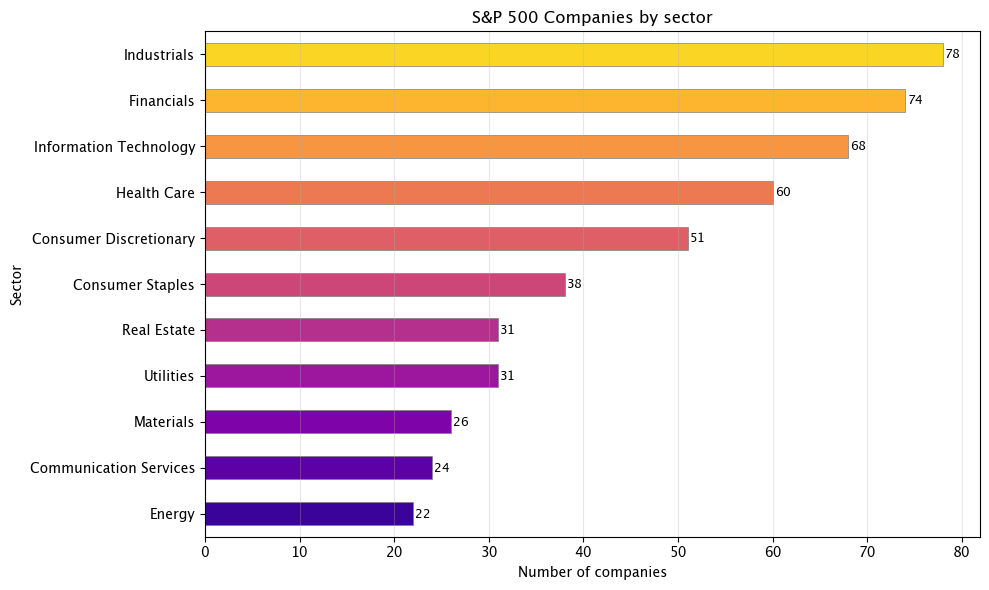

In [7]:
df.columns = df.columns.str.strip()
sector_col = next((c for c in df.columns if "sector" in c.lower()), None)
sector_counts = df[sector_col].value_counts().sort_values(ascending=True)
sector_proportion = sector_counts / sector_counts.sum()

print((sector_proportion * 100).round(2).astype(str) + "%")

fig, ax3 = plt.subplots(figsize=(10, 6))
sector_counts.plot(kind="barh", ax=ax3, color=sns.color_palette("plasma", len(sector_counts)), edgecolor="gray", linewidth=0.5)

for i, v in enumerate(sector_counts):
    ax3.text(
        v + 0.2, 
        i, 
        str(v), 
        color="black", 
        va="center", 
        fontsize=9
    )

ax3.set_xlabel("Number of companies")
ax3.set_ylabel("Sector")
ax3.set_title("S&P 500 Companies by sector")
ax3.grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.show()

### Stratified Sampling

We sample 50 companies (or 10%) of the S&P 500 with a representative proportion in each sector. Below are the companies obtained from the sampling.

In [160]:
# Stratified random sampling

sample_size = 50
sector_sample_counts = (sector_proportion * sample_size).round(0).astype(int)

sampled_stocks = []
for sector_name, sector_data in df.groupby(sector_col):
    n = min(sector_sample_counts.get(sector_name, 0), len(sector_data))
    if n > 0:
        sampled_stocks.append(sector_data.sample(n=n, random_state=42))

final_sample = pd.concat(sampled_stocks).reset_index(drop=False)

if len(final_sample) > sample_size:
    final_sample = final_sample.sample(n=sample_size, random_state=42)
elif len(final_sample) < sample_size:
    extra = df.drop(final_sample.index).sample(n=sample_size - len(final_sample), random_state=42)
    final_sample = pd.concat([final_sample, extra])

print("\t50 Companies in the Sample\n")
print(final_sample["Security"])

	50 Companies in the Sample

0     Interpublic Group of Companies (The)
1           Paramount Skydance Corporation
2                           Tapestry, Inc.
3                              Ross Stores
4                           Tractor Supply
5                                 Domino's
6                          Las Vegas Sands
7                                    Sysco
8                 Walgreens Boots Alliance
9                 Campbell's Company (The)
10                             Dollar Tree
11                         APA Corporation
12                      Marathon Petroleum
13                    Ameriprise Financial
14                              S&P Global
15                     Cboe Global Markets
16                                   Aflac
17                           Everest Group
18                    Willis Towers Watson
19                         Bank of America
20                     Abbott Laboratories
21                    Baxter International
22                       

In [ ]:
import plotly.express as px
from IPython.display import display, HTML

name_col = "Security"
sunburst_data = final_sample[[sector_col, name_col]].copy()
sunburst_data.columns = ['Sector', 'Company']

fig = px.sunburst(sunburst_data, path=['Sector', 'Company'], color_discrete_sequence=px.colors.sequential.Plasma)
fig.update_layout(
    title=dict(
        text="Stratified Sample by Sector",
        x=0.5,
        xanchor='center',
        font=dict(size=20)  
    ),
    height=700,
    font=dict(size=11, color="black")
)
display(HTML(fig.to_html(include_plotlyjs='cdn')))  

## 4. Identifying Crashes

In [11]:
sp500 = yf.download('^GSPC', start=start_date, end=end_date) # ^GSPC refers to the S&P 500 index
sp500

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2015-01-02,2058.199951,2072.360107,2046.040039,2058.899902,2708700000
2015-01-05,2020.579956,2054.439941,2017.339966,2054.439941,3799120000
2015-01-06,2002.609985,2030.250000,1992.439941,2022.150024,4460110000
2015-01-07,2025.900024,2029.609985,2005.550049,2005.550049,3805480000
2015-01-08,2062.139893,2064.080078,2030.609985,2030.609985,3934010000
...,...,...,...,...,...
2025-12-23,6909.790039,6910.879883,6868.810059,6872.410156,3820560000
2025-12-24,6932.049805,6937.319824,6904.910156,6904.910156,1798270000


### How Many S&P 500 Crashes Since 2015?

In [ ]:
sp500["Daily Return"] = sp500["Close"].pct_change()
mu = sp500["Daily Return"].mean()
sigma = sp500["Daily Return"].std()
crash_threshold = mu - 2 * sigma

# Crash days
crash_days = sp500[sp500["Daily Return"] < crash_threshold]
number_of_crashes = len(crash_days)

print(f"Full-sample mean daily return: {(mu*100).round(3)}%")
print(f"Standard deviation of daily returns: {(sigma*100).round(3)}%")
print(f"Crash threshold: {(crash_threshold*100).round(3)}%")
print(f"Number of days the S&P 500 fell below this threshold: {number_of_crashes}")
print("\nDates of these crashes and their returns:")
print((crash_days['Daily Return'] * 100).round(3).astype(str) + "%")

Full-sample mean daily return: 0.05%
Standard deviation of daily returns: 1.128%
Crash threshold: -2.207%
Number of days the S&P 500 fell below this threshold: 76

Dates of these crashes and their returns:
Date
2015-08-21    -3.185%
2015-08-24    -3.941%
2015-09-01    -2.958%
2015-09-28    -2.567%
2016-01-07     -2.37%
               ...   
2025-04-04    -5.975%
2025-04-10    -3.461%
2025-04-16    -2.241%
2025-04-21    -2.357%
2025-10-10    -2.711%
Name: Daily Return, Length: 76, dtype: str


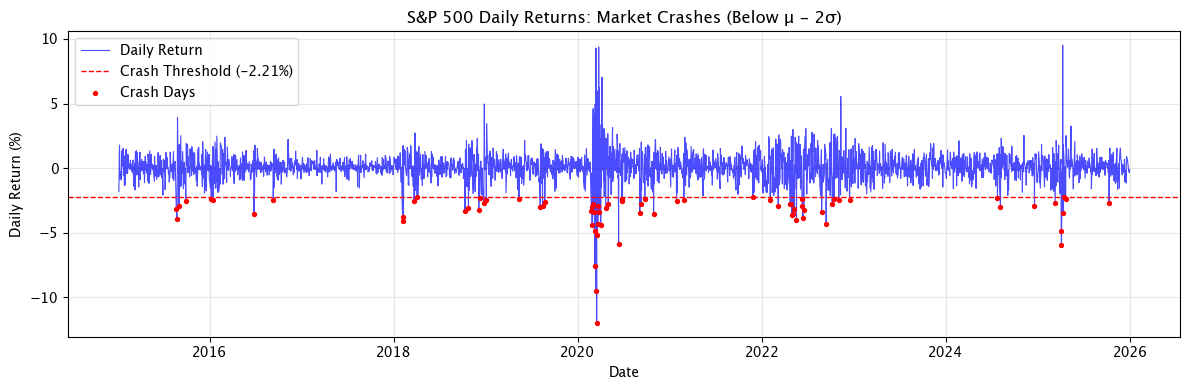

In [ ]:
fig, ax3 = plt.subplots(figsize=(12, 4))

ax1.plot(sp500.index, sp500["Daily Return"] * 100, label='Daily Return', linewidth=0.8, color="blue", alpha=0.7)
ax1.axhline(y=crash_threshold*100, color='red', linestyle='--', linewidth=1, label=f'Crash Threshold ({(crash_threshold*100).round(2)}%)')
ax1.scatter(crash_days.index, crash_days['Daily Return'] * 100, color='red', s=8, zorder=5, label='Crash Days')

ax1.set_xlabel("Date")
ax1.set_ylabel('Daily Return (%)')
ax1.set_title('S&P 500 Daily Returns: Market Crashes (Below μ - 2σ)')
ax1.legend()
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
